# MadMiner particle physics tutorial

# Part 3b: Training a score estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3a of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

Make sure you've run the first tutorial before executing this notebook!

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ScoreEstimator


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [3]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
# sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

12:43 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
12:43 madminer.analysis    INFO    Found 2 parameters
12:43 madminer.analysis    INFO    Did not find nuisance parameters
12:43 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
12:43 madminer.analysis    INFO    Found 3 observables
12:43 madminer.analysis    INFO    Found 14839 events
12:43 madminer.analysis    INFO    Found morphing setup with 6 components


The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. As in part 3a of the tutorial, for the argument `theta` you can use the helper functions `sampling.benchmark()`, `sampling.benchmarks()`, `sampling.morphing_point()`, `sampling.morphing_points()`, and `sampling.random_morphing_points()`.

In [4]:
x, theta, t_xz, _ = sampler.sample_train_local(
    theta=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train_score'
)

12:43 madminer.sampling    INFO    Extracting training sample for local score regression. Sampling and score evaluation according to ('benchmark', 'sm')
12:43 madminer.sampling    INFO    Starting sampling serially
12:43 madminer.sampling    INFO    Sampling from parameter point 1 / 1
12:43 madminer.sampling    INFO    Effective number of samples: 52.87898803697575


We can use the same data as in part 3a, so you only have to execute this if you haven't gone through tutorial 3a:

In [5]:
_ = sampler.sample_test(
    theta=sampling.benchmark('sm'),
    n_samples=1000,
    folder='./data/samples',
    filename='test'
)

12:43 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to ('benchmark', 'sm')
12:43 madminer.sampling    INFO    Starting sampling serially
12:43 madminer.sampling    INFO    Sampling from parameter point 1 / 1
12:43 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [0. 0.]: (0.000475 +/- 0.000050) pb (10.571289885945268 %). Skipping these warnings in the future...
12:43 madminer.sampling    INFO    Effective number of samples: 11.720012133050693


## 2. Train score estimator

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

The central object for this is the `madminer.ml.ScoreEstimator` class:

In [6]:
estimator = ScoreEstimator(n_hidden=(50,))

In [7]:
estimator.train(
    method='sally',
    x='data/samples/x_train_score.npy',
    t_xz='data/samples/t_xz_train_score.npy',
)

estimator.save('models/sally')

12:43 madminer.ml          INFO    Starting training
12:43 madminer.ml          INFO      Batch size:             200
12:43 madminer.ml          INFO      Optimizer:              amsgrad
12:43 madminer.ml          INFO      Epochs:                 50
12:43 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
12:43 madminer.ml          INFO      Validation split:       0.25
12:43 madminer.ml          INFO      Early stopping:         True
12:43 madminer.ml          INFO      Scale inputs:           True
12:43 madminer.ml          INFO      Shuffle labels          False
12:43 madminer.ml          INFO      Samples:                all
12:43 madminer.ml          INFO    Loading training data
12:43 madminer.ml          INFO    Found 100000 samples with 2 parameters and 3 observables
12:43 madminer.ml          INFO    Rescaling inputs
12:43 madminer.ml          INFO    Creating model
12:43 madminer.ml          INFO    Training model
12:43 madminer.utils.

## 3. Evaluate score estimator

Let's evaluate the SM score on the test data

In [8]:
estimator.load('models/sally')

t_hat = estimator.evaluate_score(
    x='data/samples/x_test.npy'
)

Let's have a look at the estimated score and how it is related to the observables:

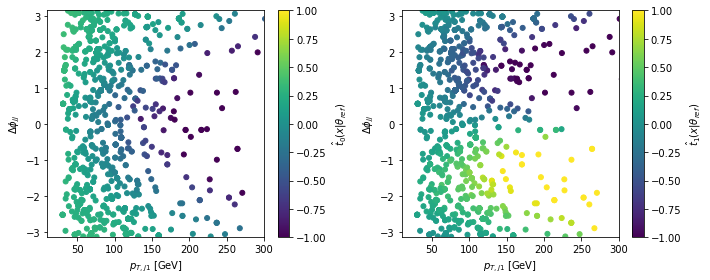

In [13]:
x = np.load('data/samples/x_test.npy')

fig = plt.figure(figsize=(10,4))

for i in range(2):
    
    ax = plt.subplot(1,2,i+1)

    sc = plt.scatter(x[:,0], x[:,1], c=t_hat[:,i], s=25., cmap='viridis', vmin=-1., vmax=1.)
    cbar = plt.colorbar(sc)

    cbar.set_label(r'$\hat{t}_' + str(i) + r'(x | \theta_{ref})$')
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    plt.xlim(10.,300.)
    plt.ylim(-3.15,3.15)
    
plt.tight_layout()
plt.show()
